In [0]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_mean_and_CI(mean, lb, ub, color_shading=None):
    plt.plot(mean, 'r', zorder=10)
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=0.4, zorder=15)

In [0]:
#class for environment

class environment():
    
    #environment initializer
    
    def __init__(self, init_s):
        
        #ititial temperature and degree of ventilation
        
        self.t, self.vent_degree = init_s
        
    #step of environment, driven by a
        
    def step(self, a):
        
        #control parameters
        
        heat, vent = a
        
        #update of parameters
        
        self.t = self.t - 0.01*self.t + 0.6*heat + 0.04*vent - 0.004*self.t*vent - 0.0005*self.t ** 2
        
        #checking of boundaries
        
        if self.t<0:
            self.t = 0
        elif self.t>35:
            self.t = 35
            
        self.vent_degree = self.vent_degree - (1 - vent) + 3*vent
        
        if self.vent_degree<0:
            self.vent_degree = 0
        elif self.vent_degree>60:
            self.vent_degree = 60
            
        #return new parameters of environment
            
        return self.t, self.vent_degree
      
    #sample session with random control

    def random_session(self, num_of_steps, sigma):
        collection_a = []
        collection_t = []
        collection_noisy_t = []
        t = self.t
        noisy_t = t
        a = 3
        for i in range(num_of_steps):
            collection_t.append(t)
            collection_noisy_t.append(noisy_t)
            if 0.3 > np.random.rand():
                a = np.random.choice(4)
            collection_a.append(a)
            a_for_agent = np.unravel_index(a, (2, 2))
            t, _ = self.step(a_for_agent)
            noisy_t = t + sigma*np.random.randn()
        return np.array(collection_t), np.array(collection_noisy_t), np.array(collection_a)

In [0]:
#generate training set
env = environment((20, 20))
t, noisy_t, a = env.random_session(300 * 16, 1.)
t = t.reshape((16, 300))
noisy_t = noisy_t.reshape((16, 300))
a = a.reshape((16, 300))

We need to minimize the following expression:
$$\sum_{i=1}^{N}\left[\log(\sqrt{2\pi}s)+\log(\sqrt{2\pi}\eta)+\frac{(T_i - \xi_i(T))^2}{2s^2} + \frac{\sigma^2_i(T)}{2s^2} + \frac{\sigma^2_i(T)}{2\eta^2} + \frac{\xi_i^2(T) + \left\langle F(\sigma_{i-1}(T)\epsilon_{i-1} + \xi_{i-1}(T))^2\right\rangle - 2\xi_i(T)\left\langle F(\sigma_{i-1}(T)\epsilon_{i-1} + \xi_{i-1}(T))\right\rangle}{2\eta^2} + \log\left[\sqrt{2\pi}\sigma_i(T)\right] + \frac{1}{2}\right]$$

In [0]:
#conv 1d layer, is needed for denoising
def conv_1d_layer(input_value, channels_in, channels_out, name, activation=True, filter_size=16):
    with tf.name_scope(name):
        w = tf.get_variable(shape=(filter_size, channels_in, channels_out), name='w'+name, initializer=tf.initializers.he_uniform())
        b = tf.Variable(tf.zeros([channels_out]), name='b'+name)
        conv = tf.nn.conv1d(input_value, w, 1, "SAME", name='conv')
        if activation == True:
            act = tf.nn.elu(conv + b)
        else:
            act = conv + b
    return act

#model training
def train(sess, states, actions, number_of_steps=10000):
    ####lossses collection#####################################################################
    losses = []
    #####main loop#############################################################################
    for i in tqdm(range(number_of_steps)):
        l = sess.run([loss, train_step], feed_dict={actions_ph:actions, states_ph:states,\
                                                  eps_ph:np.random.randn(actions.shape[0], actions.shape[1])})[0]
        losses.append(l)
    ###########################################################################################
    return losses
    
#denoising
def t_denoising(sess, noisy_t, action):
    data = sess.run([state_out], feed_dict={actions_ph:action.reshape((1, -1)), states_ph:noisy_t.reshape((1, -1))})[0]
    pred_t = data[0, :, 0]
    sigma_t = np.exp(data[0, :, 1]/2)
    return pred_t, sigma_t
  
def prediction_t(sess, t, action):
  
    t_new = sess.run(new_t, feed_dict={temperature_ph:np.array(t).reshape((1,)), \
                                       actions_for_prediction_ph:np.array(action).reshape((1,))})
    return t_new[0]
  
def prediction_vent(sess, vent, action):

    action_one_hot = np.zeros((4))
    action_one_hot[action] = 1.
    v_new = vent + (np.array([-1, 3, -1, 3]) * action_one_hot).sum(-1)
    return v_new
    

In [5]:
tf.reset_default_graph()

# length of one session
session_length = 300
learning_rate = 0.003

#min and max temperature
t_min = 0
t_max = 30



#####log variances of normal noise in dynamical system and in observations respectively####
s = tf.constant(-5, dtype=tf.float32, name='log_variance_transition')
eta = tf.Variable(-5, dtype=tf.float32, name='log_variance_measurement')
###########################################################################################

####weights which parametrize dynamics of hidden variables#################################
with tf.name_scope('weights'):
    W1 = tf.get_variable(shape=(5, 32), dtype=tf.float32, name='W1')
    b1 = tf.get_variable(shape=(32,), dtype=tf.float32, name='b1')
    W2 = tf.get_variable(shape=(32, 8), dtype=tf.float32, name='W2')
    b2 = tf.get_variable(shape=(8,), dtype=tf.float32, name='b2')
    W3 = tf.get_variable(shape=(8, 1), dtype=tf.float32, name='W3')
    b3 = tf.get_variable(shape=(1,), dtype=tf.float32, name='b3')
###########################################################################################

####placeholders for actions, states, auxiliary random variables###########################
actions_ph = tf.placeholder(shape=(None, session_length), dtype=tf.int32, name='actions_ph')
states_ph = tf.placeholder(shape=(None, session_length), dtype=tf.float32, name='states_ph')
eps_ph = tf.placeholder(shape=(None, session_length), dtype=tf.float32, name='eps_ph')
###########################################################################################

####concatenation of states and actions####################################################
states_and_actions = tf.concat([tf.expand_dims(tf.cast(actions_ph, dtype=tf.float32),\
              axis=-1), tf.expand_dims(states_ph, axis=-1)], axis=-1, name='concat')
###########################################################################################


#####decoder (denoiser)####################################################################
conv1 = conv_1d_layer(states_and_actions, 2, 8, filter_size=8, name='conv1')
conv2 = conv_1d_layer(conv1, 8, 32, filter_size=8, name='conv2')
conv3 = conv_1d_layer(conv2, 32, 8, filter_size=8, name='conv3')
state_out = conv_1d_layer(conv3, 8, 2, filter_size=8, name='conv4', activation=False)
with tf.name_scope('separation'):
    #hidden variables
    mu = state_out[:, :, 0]
    #variance of hidden variables
    sigma = state_out[:, :, 1]
###########################################################################################

####one hot representation of actions######################################################
one_hot_action = tf.one_hot(actions_ph, axis=-1, depth=4, name='one_hot_action')
###########################################################################################

####data preparation before passing through dynamical map##################################
with tf.name_scope('true_state'):
    true_state = mu + tf.exp(sigma/2) * eps_ph

input_for_transformation = tf.concat([one_hot_action, tf.expand_dims(true_state, axis=-1)]\
                                     , axis=-1, name='input_for_transformation')

input_for_transformation = tf.reshape(input_for_transformation, shape=(-1, 5),\
                                                              name='reshape')
###########################################################################################

####passing through dynamical map##########################################################
with tf.name_scope('net_in_time'):
    h1 = tf.matmul(input_for_transformation, W1) + b1
    h1 = tf.nn.elu(h1)
    h2 = tf.matmul(h1, W2) + b2
    h2 = tf.nn.elu(h2)
    infinitesimal_transform = tf.matmul(h2, W3) + b3
    infinitesimal_transform = tf.reshape(infinitesimal_transform,\
                                         shape=(-1, session_length))
    new_state = true_state + infinitesimal_transform
###########################################################################################

####shifting data in time##################################################################
with tf.name_scope('time_shift'):
    mu = mu[:, 1:]
    sigma = sigma[:, 1:]
    T = states_ph[:, 1:]
    eps = eps_ph[:, 1:]
    F = new_state[:, :-1]
###########################################################################################


####sigma term#############################################################################
with tf.name_scope('sigma_term'):
    sigma_term = tf.exp(sigma) * (1 / (2 * tf.exp(s)) + 1 / (2 * tf.exp(eta)))
###########################################################################################

####regularization term####################################################################
with tf.name_scope('regularization_term'):
    regularization_term = tf.pow(mu - F, 2) / (2 * tf.exp(s))
###########################################################################################

####log sigma term#########################################################################
with tf.name_scope('log_sigma_term'):
    log_sigma_term = -sigma/2
###########################################################################################

####regression term########################################################################
with tf.name_scope('regression_term'):
    regression_term = tf.pow(T - mu, 2) / (2 * tf.exp(eta))
###########################################################################################

####loss function##########################################################################
with tf.name_scope('loss'):
    loss = tf.reduce_mean(sigma_term + regularization_term + \
                          log_sigma_term + regression_term + s/2 + eta/2)
###########################################################################################

####training###############################################################################
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
###########################################################################################

####placeholder for dynamics prediction####################################################
actions_for_prediction_ph = tf.placeholder(shape=(None,), dtype=tf.int32, \
                                           name='actions_for_prediction_ph')
temperature_ph = tf.placeholder(shape=(None), dtype=tf.float32, name='temperature_ph')
###########################################################################################

####concatenate one hot action and temperature#############################################
one_hot_action_prediction = tf.one_hot(actions_for_prediction_ph, 4, axis=-1,\
                               name='one_hot_actions')
input_t_and_a = tf.concat([one_hot_action_prediction, \
                  tf.expand_dims(temperature_ph, axis=-1)], axis=-1, name='input_t_and_a')
###########################################################################################

####prediction of dynamisc#################################################################
with tf.name_scope('for_prediction'):
    h1 = tf.matmul(input_t_and_a, W1) + b1
    h1 = tf.nn.elu(h1)
    h2 = tf.matmul(h1, W2) + b2
    h2 = tf.nn.elu(h2)
    infinitesimal_trnsfrm = (tf.matmul(h2, W3) + b3)[:, 0]
    new_t = temperature_ph + infinitesimal_trnsfrm
###########################################################################################
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
#Training
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
losses = train(sess, noisy_t, a, number_of_steps=100000)
save_path = saver.save(sess, "/model.ckpt")

100%|██████████| 100000/100000 [09:59<00:00, 166.91it/s]


In [7]:
#Upload saved model
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, "/model.ckpt")

INFO:tensorflow:Restoring parameters from /model.ckpt


NameError: ignored

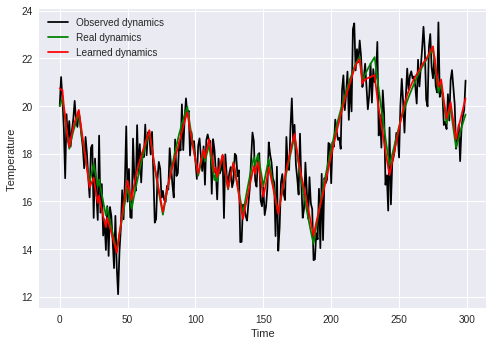

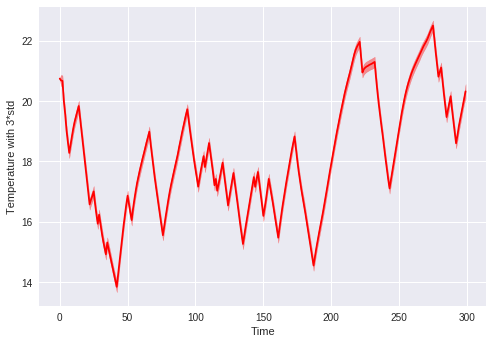

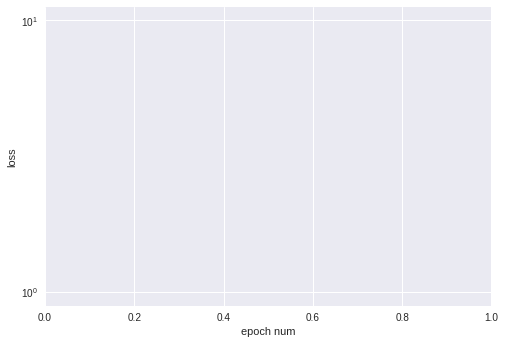

In [8]:
#Denoised t and its std
pred_t, sigma_t = t_denoising(sess, noisy_t[0], a[0])
#True dynamics and its noisy version
true_t, true_noisy_t = t[0], noisy_t[0]

#plotting
fig1 = plt.figure()
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.plot(true_noisy_t, 'black', zorder=1)
plt.plot(true_t, 'green', zorder=5)
plt.plot(pred_t, 'red', zorder=10)
plt.legend(['Observed dynamics', 'Real dynamics', 'Learned dynamics'])
plt.savefig(fname='fig')
fig2 = plt.figure()
plt.xlabel('Time')
plt.ylabel('Temperature with 3*std')
plot_mean_and_CI(pred_t, pred_t - 3*sigma_t, pred_t + 3*sigma_t, color_shading='red')
fig3 = plt.figure()
plt.ylabel('loss')
plt.xlabel('epoch num')
plt.yscale('log')
plt.plot(losses, 'blue')
plt.show()

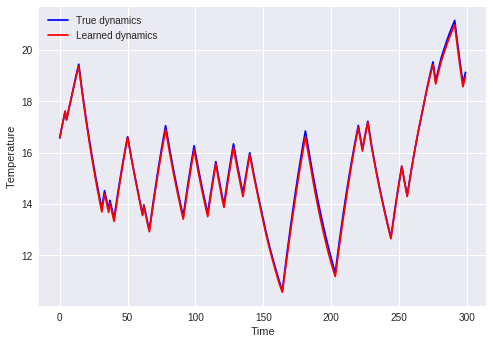

In [9]:
#initial parameters
collection_t_true = []
collection_t_predicted = []
t_true = env.t
t_predicted = np.array(t_true).reshape((1,))
a = 3

#main loop
for i in range(300):
    collection_t_true.append(t_true)
    collection_t_predicted.append(t_predicted)

    #pick action randomly with probability 0.2
    if 0.2 > np.random.rand():
        a = np.random.choice(4)
    
    #calculation of true and predicted values of t
    t_predicted = prediction_t(sess, t_predicted, a)
    a_for_agent = np.unravel_index(a, (2, 2))
    t_true, _ = env.step(a_for_agent)
    
#plotting
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.plot(collection_t_true, 'blue')
plt.plot(collection_t_predicted, 'red')
plt.legend(['True dynamics', 'Learned dynamics'])

In [0]:
#this function makes one time step transition 
def time_evolution_planing(sess, states, actions):
  
    t_old = states[:, 0]
    v_old = states[:, 1]
    t_new = sess.run(new_t, feed_dict={temperature_ph:t_old, actions_for_prediction_ph:actions})
    action_one_hot = np.zeros((actions.shape[0], 4))
    action_one_hot[np.arange(actions.shape[0]), actions] = 1.
    v_new = v_old + (np.array([-1, 3, -1, 3]) * action_one_hot).sum(-1)
    reward = -(4 * (t_old > 21) * (t_old - 21) +\
                  4 * (t_old < 18) * (18 - t_old) + 4 * (v_old < 30) * (30 - v_old)\
                + 4 * (v_old > 60) * (v_old - 60) + (np.array([0., 1., 1., 2.]) * action_one_hot).sum(-1))
    #reward = -(np.abs(t_old - 21) + np.abs(v_old - 35) + (np.array([0., 1., 1., 2.]) * action_one_hot).sum(-1))
    return np.append(t_new.reshape((-1, 1)), v_new.reshape((-1, 1)), axis=-1), reward

#this function expands set of actions
def actions_expand(actions):
    actions_shape = actions.shape
    add_a = np.kron(np.array([0, 1, 2, 3]), np.ones(actions_shape[-1], dtype=np.int32))
    a = np.append(np.append(actions, actions, axis=-1), np.append(actions, actions, axis=-1), axis=-1)
    return np.append(a, np.expand_dims(add_a, axis=0), axis=0)
    
#this function expands set of states
def states_expand(states):
    return np.append(np.append(states, states, axis=0), np.append(states, states, axis=0), axis=0)
  
#this fucntion expands set of q
def q_expand(q):
    return np.append(np.append(q, q), np.append(q, q))
  
#this function builts mask for selection of the best trajectories
def mask_select_best(q):
    ind = q.argsort()
    ind = ind.argsort()
    return np.append(np.array(((3 * q.shape[0])//4*[False])), np.array((q.shape[0]//4)*[True]))[ind]
  
#this function makes prediction of the best action using planing
def opt_action(sess, in_state, depth=30, degree=16):
    ####initial q, actions, states##################
    q = np.zeros(4)
    actions = np.array([0, 1, 2, 3]).reshape((1, 4))
    states = in_state.reshape((1, 2))
    states = states_expand(states)
    ################################################
    #############main loop##########################
    for j in range(depth):
        #next state and reward
        states, reward = time_evolution_planing(sess, states, actions[-1])
        #update of q
        q = q + reward
        #truncate number of trajectories if it is too many (select best)
        if q.shape[0] > 2 ** degree:
            mask = mask_select_best(q)
            actions = actions[:, mask]
            q = q[mask]
            states = states[mask]
        #expand actions, states and q
        actions = actions_expand(actions)
        states = states_expand(states)
        q = q_expand(q)
    #best action selection
    return actions[0, q.argmax()]

In [0]:
##############comparison between naive policy and planning#########################################################

####initial state, the same for naiv policy and for planing########################################################
states = np.array([20., 35.]).reshape((1, 2))
states_naiv = states

####lists of all parameters########################################################################################
t_collection = []
vent_collection = []
t_naiv_collection = []
vent_naiv_collection = []
reward_opt_collection = []
reward_naiv_collection = []

####main loop######################################################################################################
for j in range(1000):
    
    #evolution of state and reward under planing
    states, reward_opt = time_evolution_planing(sess, states, opt_action(sess, states[0], degree=10).reshape((1,)))
    
    #calculation of naiv action
    actions_tuple_naiv = states_naiv[:, 0] < 19.5, states_naiv[:, 1] < 33
    actions_labels_naiv = np.ravel_multi_index(actions_tuple_naiv, (2, 2))
    
    #evolution of state and reward under naiv ploicy
    states_naiv, reward_naiv = time_evolution_planing(sess, states_naiv, actions_labels_naiv)
    
    #filling all lists
    t_collection.append(states[0, 0])
    vent_collection.append(states[0, 1])
    t_naiv_collection.append(states_naiv[0, 0])
    vent_naiv_collection.append(states_naiv[0, 1])
    reward_opt_collection.append(reward_opt)
    reward_naiv_collection.append(reward_naiv)

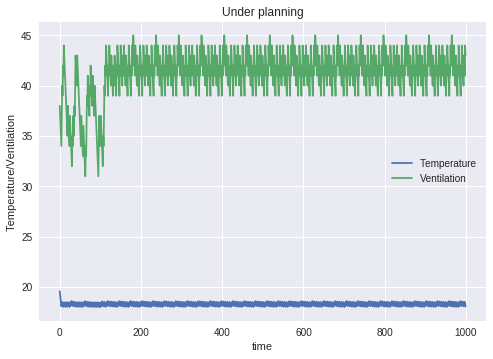

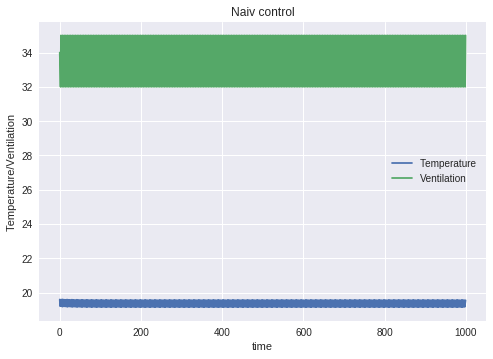

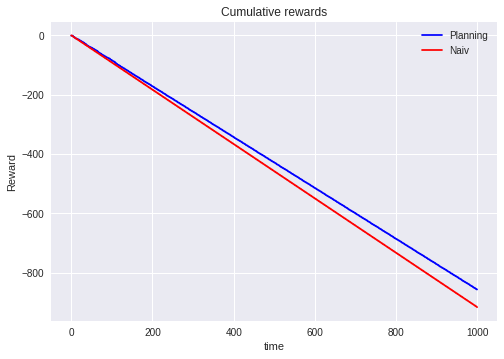

In [11]:
#plotting
fig1 = plt.figure()
plt.title('Under planning')
plt.xlabel('time')
plt.ylabel('Temperature/Ventilation')
plt.plot(t_collection)
plt.plot(vent_collection)
plt.legend(['Temperature', 'Ventilation'])
fig2 = plt.figure()
plt.title('Naiv control')
plt.xlabel('time')
plt.ylabel('Temperature/Ventilation')
plt.plot(t_naiv_collection)
plt.plot(vent_naiv_collection)
plt.legend(['Temperature', 'Ventilation'])
fig3 = plt.figure()
plt.title('Cumulative rewards')
plt.xlabel('time')
plt.ylabel('Reward')
reward_opt_collection = np.cumsum(np.array(reward_opt_collection))
reward_naiv_collection = np.cumsum(np.array(reward_naiv_collection))
plt.plot(reward_opt_collection, 'b')
plt.plot(reward_naiv_collection, 'r')
plt.legend(['Planning', 'Naiv'])

In [0]:
'''def time_evolution_v(sess, states, actions):
  
    t_old = states[:, 0]
    v_old = states[:, 1]
    t_new = sess.run(new_t, feed_dict={temperature_ph:t_old, one_hot_action_ph:actions})
    v_new = v_old + (np.array([-1, 3, -1, 3]) * actions).sum(-1)
    reward = (2 * (t_old > 21) * (t_old - 21) +\
                  2 * (t_old < 18) * (18 - t_old) + 2 * (v_old < 30) * (30 - v_old)\
                + 2 * (v_old > 60) * (v_old - 60) + (np.array([0., 1., 1., 2.]) * actions).sum(-1))
    return np.append(t_new.reshape((-1, 1)), v_new.reshape((-1, 1)), axis=-1), reward
  
number_of_states = 10000
temperatures = (t_max - t_min) * np.random.rand(number_of_states)
vents = 60 * np.random.rand(number_of_states)

states = np.append(np.expand_dims(temperatures, axis=-1), np.expand_dims(vents, axis=-1), axis=-1)
states_for_fit = states
reward_collection = []
for j in range(1000):
    actions_tuple = states[:, 0] < 20, states[:, 1] < 35
    actions_labels = np.ravel_multi_index(actions_tuple, (2, 2))
    actions = np.zeros((number_of_states, 4))
    actions[np.arange(number_of_states), actions_labels] = 1
    states, reward = time_evolution_v(sess, states, actions)
    reward_collection.append(reward)
value_estimation = np.zeros_like(reward)
for r in reward_collection[::-1]:
    value_estimation = gamma * value_estimation + r
    
loss_collection = []
for j in range(10000):
    loss, _ = sess.run([v_loss, v_train], feed_dict={states_v:states_for_fit, v_ph:value_estimation})
    loss_collection.append(loss)
def value_estimator(sess, state):
    return sess.run(value, feed_dict={states_v:np.expand_dims(state, axis=0)}).'''

In [0]:
'''gamma = 0.95

n_actions = [np.array([1., 0., 0., 0.]), np.array([0., 1., 0., 0.]), np.array([0., 0., 1., 0.]), np.array([0., 0., 0., 1.])]

def time_evolution(sess, state, action):
    t_old = np.expand_dims(state[0], axis=0)
    v_old = state[1]
    t_new = sess.run(new_t, feed_dict={temperature_ph:t_old, one_hot_action_ph:np.expand_dims(action, axis=0)})
    v_new = v_old + (np.array([-1, 3, -1, 3]) * action).sum(-1, keepdims=True)
    reward = -(2 * (t_old > 21) * (t_old - 21) +\
                  2 * (t_old < 18) * (18 - t_old) + 2 * (v_old < 30) * (30 - v_old)\
                + 2 * (v_old > 60) * (v_old - 60) + (np.array([0., 1., 1., 2.]) * action).sum(-1))
    return np.append(t_new, v_new, axis=-1), reward
  
class Node():
    
    def __init__(self, sess, parent, action):
        
        self.parent = parent
        self.action = action
        self.children = set()
        self.times_visited = 0
        self.value = 0
        self.state, self.reward = time_evolution(sess, parent.state, action)
        self.sess = sess
        
    def is_leaf(self):
        return len(self.children)==0
      
    def is_root(self):
        return self.parent is None
      
    def get_mean_value(self):
        return self.value / self.times_visited if self.times_visited !=0 else 0
        
    def ucb_score(self, scale=1, max_value=1e100):
        
        if self.times_visited == 0:
            return max_value
        
        U = scale * np.sqrt(np.log(self.parent.times_visited) / self.times_visited)
        
        return self.get_mean_value() + U
      
    def select_best_leaf(self):

        if self.is_leaf():
            return self
        
        children = self.children
        
        children_list = list(children)
        ind = np.array([i.ucb_score() for i in children_list]).argmax()
        
        best_child = children_list[ind]
        
        return best_child.select_best_leaf()
      
    def expand(self):
        
        for action in n_actions:
            self.children.add(Node(self.sess, self, action))
            
        return self.select_best_leaf()
      
    def rollout(self):
        
        return value_estimator(self.sess, self.state)
      
    def propagate(self, child_value):
        
        my_value = self.reward + child_value * gamma
        self.times_visited = self.times_visited + 1
        
        if not self.is_root():
            self.parent.propagate(my_value)
            
    def safe_delete(self):
        
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child
      
class Root(Node):
    
    def __init__(self, sess, init_state):

        self.parent = None
        self.action = None
        self.children = set()
        self.times_visited = 0
        self.value = 0
        self.reward = 0
        self.state = init_state
        self.sess = sess
        
    @staticmethod
    def as_root(node):
        root = Root(node.sess, node.state)
        return root'''

In [0]:
'''def plan_mcts(root, n_iters=10):

    for _ in range(n_iters):

        node = root.select_best_leaf()
        exp_node = node.expand()
        rollout_reward = exp_node.rollout()
        exp_node.propagate(rollout_reward)'''

In [0]:
'''root = Root(sess, np.array([20., 20.]))
tree = plan_mcts(root, n_iters=10000)
n = root
states_collection = []
for i in range(10):
    states_collection.append(n.state)
    ch = n.children
    list_ch = list(ch)
    ch_values = [i.value for i in list_ch]
    n = list_ch[np.array(ch_values).argmax()]'''

'root = Root(sess, np.array([20., 20.]))\ntree = plan_mcts(root, n_iters=10000)\nn = root\nstates_collection = []\nfor i in range(10):\n    states_collection.append(n.state)\n    ch = n.children\n    list_ch = list(ch)\n    ch_values = [i.value for i in list_ch]\n    n = list_ch[np.array(ch_values).argmax()]'